In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

# Remove objects with large sky residuals
for band in ['g', 'r', 'z']:
    subs[band+'_sky'] = (subs['apflux_blobresid_'+band][:, -1]-subs['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (subs['g_sky']>-0.002*2) & (subs['g_sky']<0.002*2)
print(np.sum(mask)/len(mask))
mask &= (subs['r_sky']>-0.003*2) & (subs['r_sky']<0.003*2)
print(np.sum(mask)/len(mask))
mask &= (subs['z_sky']>-0.006*2) & (subs['z_sky']<0.006*2)
print(np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

# Only keep isolated sources
mask = (subs['fracflux_g']>-0.01) & (subs['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_r']>-0.01) & (subs['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_z']>-0.01) & (subs['fracflux_z']<0.01)
print(np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

# tmp = Table()
# tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
# tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104
0.9313085551999488
0.882942287064733
0.782445358169604
2153371
0.6551885392716815
0.6204875982819495
0.5836119275312986
1256733


In [5]:
mask = subs['sub']=='sub-5'
sub1 = subs[mask].copy()
print(len(sub1))

mask = subs['sub']=='sub-4'
sub2 = subs[mask].copy()
print(len(sub2))

108141
99783


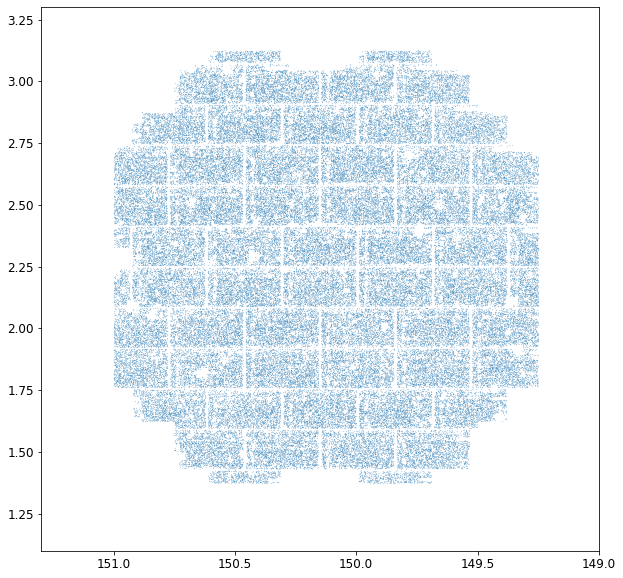

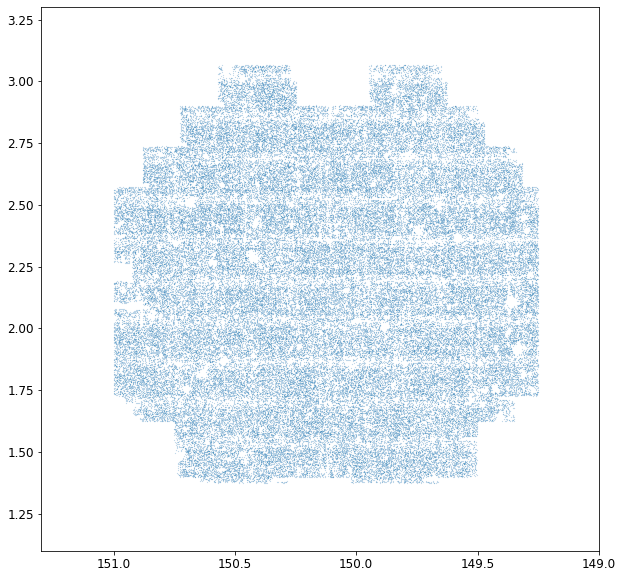

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(sub2['ra'], sub2['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

Doubly matched objects = 0
Final matched objects = 61490


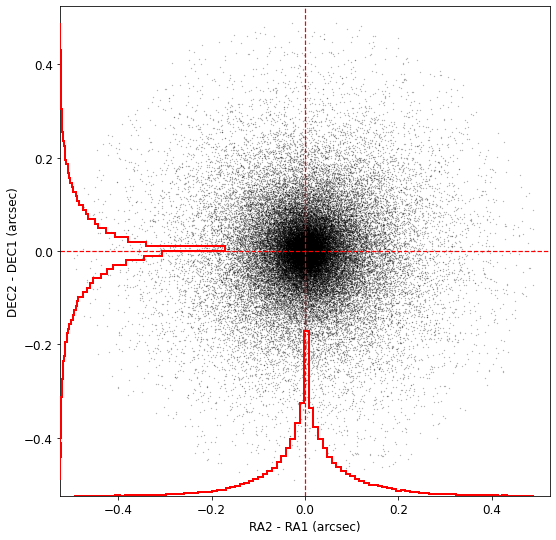

In [7]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], sub2['ra'], sub2['dec'], search_radius=0.5, plot_q=True)

sub1 = sub1[idx1]
sub2 = sub2[idx2]

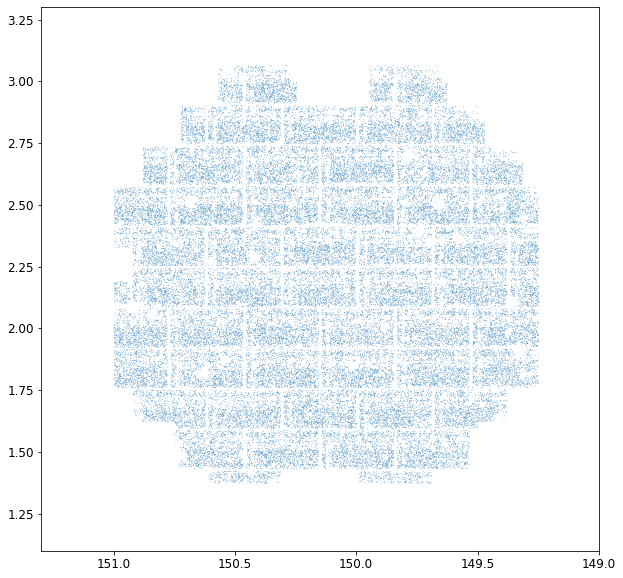

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

In [10]:
mask0 = sub1['rmag']>18.
mask0 &= sub1['rmag']<23.5
mask0 &= sub1['type']=='PSF'
print(np.sum(mask0))

mask0 &= sub2['rmag']>18.
mask0 &= sub2['rmag']<23.5
mask0 &= sub2['type']=='PSF'
print(np.sum(mask0))

7925
7083


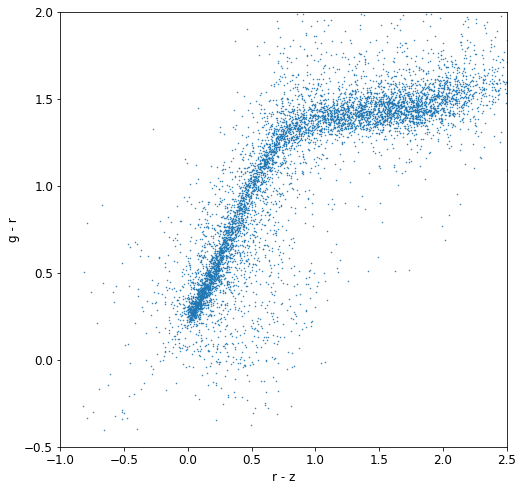

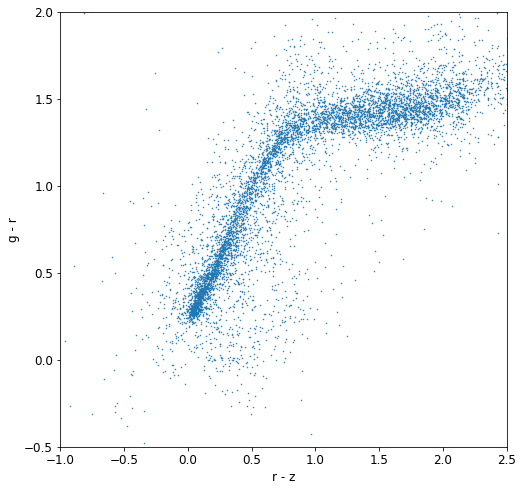

In [11]:
plt.figure(figsize=(8, 8))
plt.plot((sub1['rmag']-sub1['zmag'])[mask0], (sub1['gmag']-sub1['rmag'])[mask0], '.', ms=1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((sub2['rmag']-sub2['zmag'])[mask0], (sub2['gmag']-sub2['rmag'])[mask0], '.', ms=1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

median = 0.009
sigma_nmad       = 1.112
sigma_percentile = 1.133


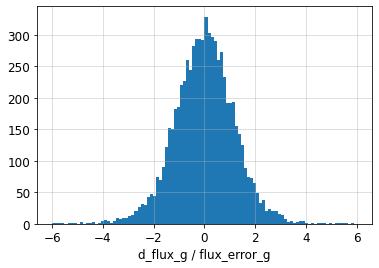

median = -0.007
sigma_nmad       = 1.146
sigma_percentile = 1.170


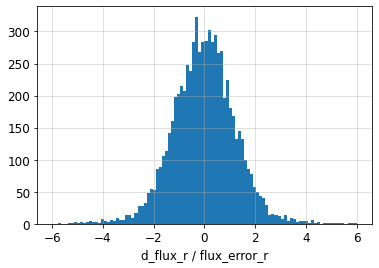

median = -0.051
sigma_nmad       = 1.199
sigma_percentile = 1.230


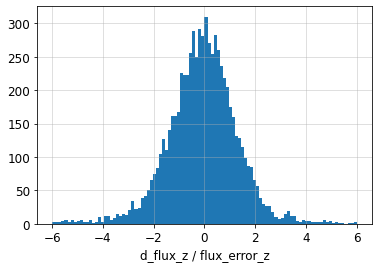

In [13]:
for band in ['g', 'r', 'z']:
    v = (sub2['flux_'+band]-sub1['flux_'+band]) / np.sqrt(1/sub2['flux_ivar_'+band]+1/sub1['flux_ivar_'+band])
    # v = (sub2[band+'mag']-sub1[band+'mag']) / sub2[band+'magerr']  # magnitude
    v = v[mask0]
    print('median = {:.3f}'.format(np.nanmedian(v)))
    print('sigma_nmad       = {:.3f}'.format(nmad(v)))
    print('sigma_percentile = {:.3f}'.format((np.percentile(v, 84.1)-np.percentile(v, 15.9))/2))
    plt.hist(v, 100, range=(-6, 6))
    plt.xlabel('d_flux_{} / flux_error_{}'.format(band, band, band))
    plt.grid(alpha=0.5)
    plt.show()

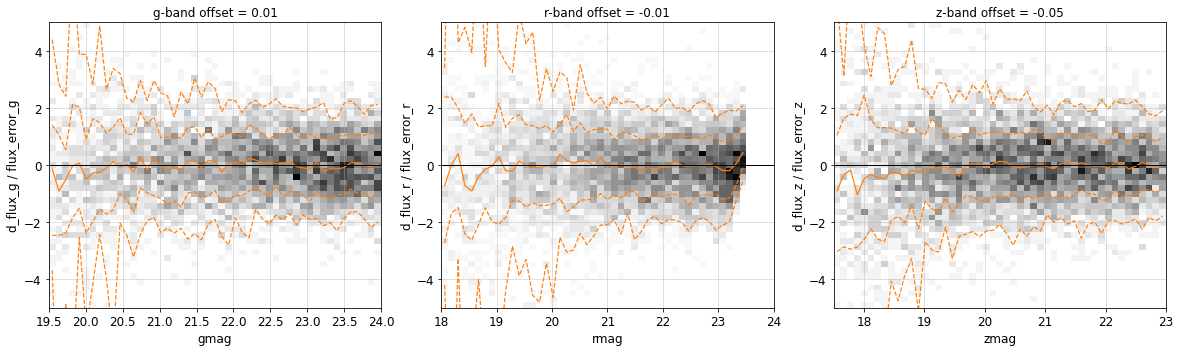

In [14]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-5, 5], [-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'mag'
    v = (sub2['flux_'+band]-sub1['flux_'+band]) / np.sqrt(1/sub2['flux_ivar_'+band]+1/sub1['flux_ivar_'+band])
    x = sub1[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('{}-band offset = {:.2f}'.format(band, median_offset))
    ax.set_xlabel(mag_col)
    ax.set_ylabel('d_flux_{} / flux_error_{}'.format(band, band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

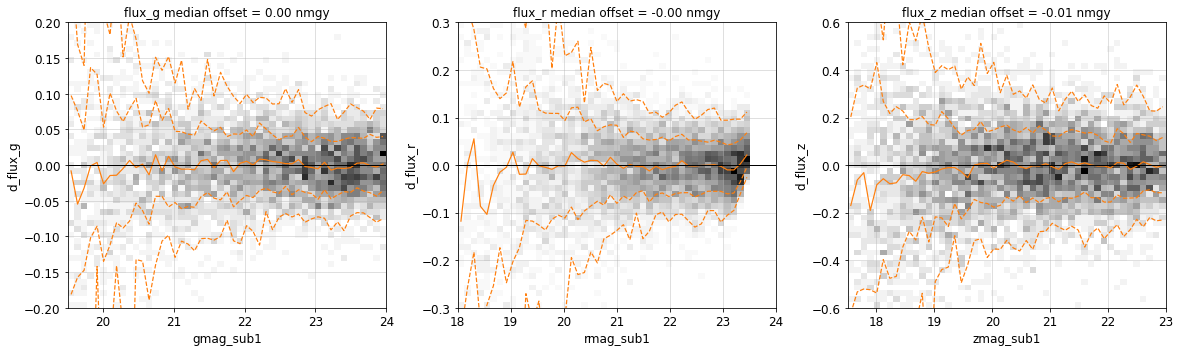

In [15]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-0.2, 0.2], [-0.3, 0.3], [-0.6, 0.6]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'mag'
    v = (sub2['flux_'+band]-sub1['flux_'+band])
    x = sub1[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('flux_{} median offset = {:.2f} nmgy'.format(band, median_offset))
    ax.set_xlabel(mag_col+'_sub1')
    ax.set_ylabel('d_flux_{}'.format(band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

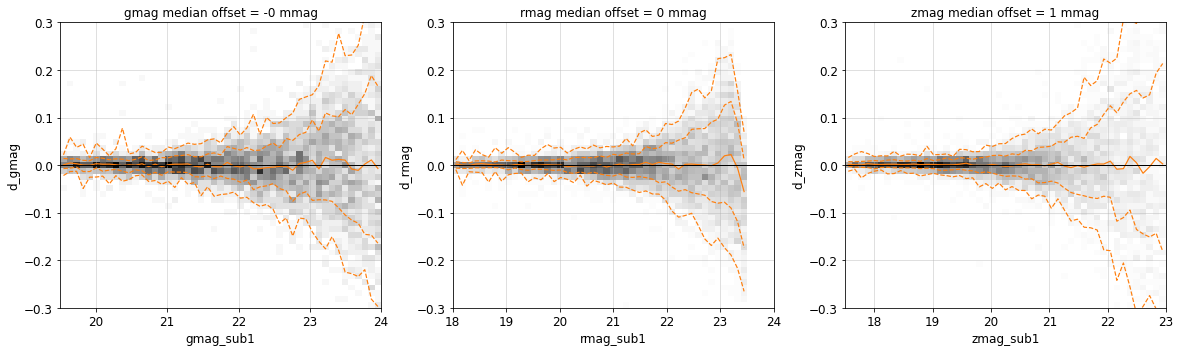

In [16]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-0.3, 0.3], [-0.3, 0.3], [-0.3, 0.3]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = band+'mag'
    v = sub2[mag_col] - sub1[mag_col]
    x = sub1[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.percentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('{} median offset = {:.0f} mmag'.format(mag_col, median_offset*1000))
    ax.set_xlabel(mag_col+'_sub1')
    ax.set_ylabel('d_'+mag_col)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

-----

In [17]:
# Fainter sources only

mask0 = sub1['rmag']>22.5
mask0 &= sub1['rmag']<23.5
mask0 &= sub1['type']=='PSF'
print(np.sum(mask0))

mask0 &= sub2['rmag']>22.5
mask0 &= sub2['rmag']<23.5
mask0 &= sub2['type']=='PSF'
print(np.sum(mask0))

2949
2104


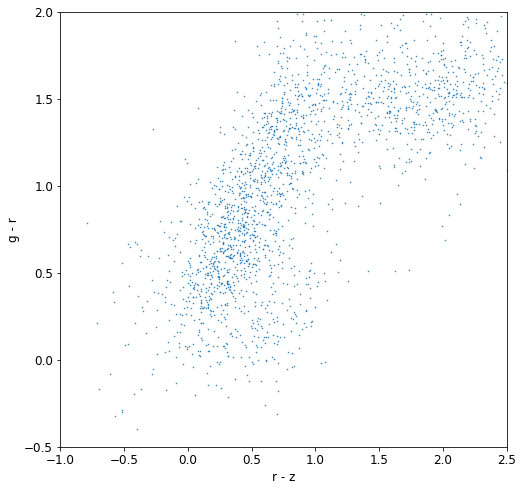

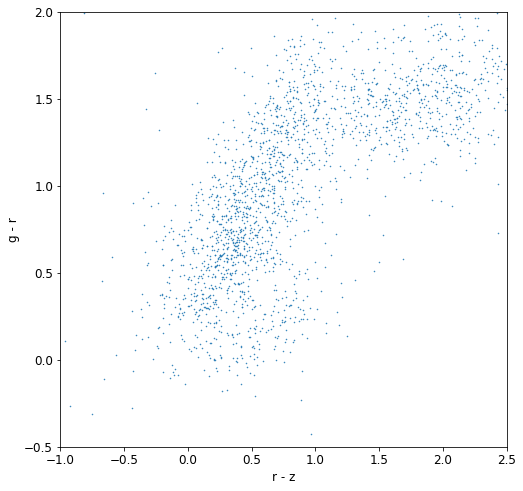

In [18]:
plt.figure(figsize=(8, 8))
plt.plot((sub1['rmag']-sub1['zmag'])[mask0], (sub1['gmag']-sub1['rmag'])[mask0], '.', ms=1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((sub2['rmag']-sub2['zmag'])[mask0], (sub2['gmag']-sub2['rmag'])[mask0], '.', ms=1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

median = 0.011
sigma_nmad       = 1.007
sigma_percentile = 1.006


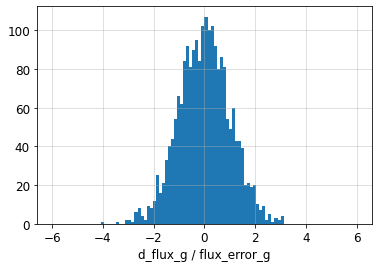

median = -0.006
sigma_nmad       = 0.918
sigma_percentile = 0.973


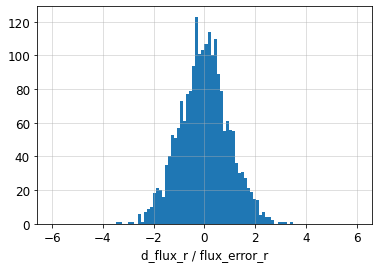

median = 0.006
sigma_nmad       = 1.046
sigma_percentile = 1.045


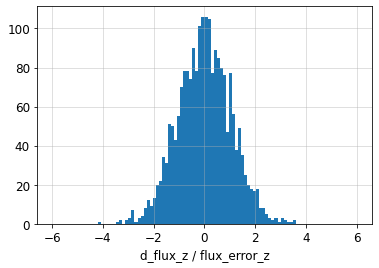

In [19]:
for band in ['g', 'r', 'z']:
    v = (sub2['flux_'+band]-sub1['flux_'+band]) / np.sqrt(1/sub2['flux_ivar_'+band]+1/sub1['flux_ivar_'+band])
    # v = (sub2[band+'mag']-sub1[band+'mag']) / sub2[band+'magerr']  # magnitude
    v = v[mask0]
    print('median = {:.3f}'.format(np.nanmedian(v)))
    print('sigma_nmad       = {:.3f}'.format(nmad(v)))
    print('sigma_percentile = {:.3f}'.format((np.percentile(v, 84.1)-np.percentile(v, 15.9))/2))
    plt.hist(v, 100, range=(-6, 6))
    plt.xlabel('d_flux_{} / flux_error_{}'.format(band, band, band))
    plt.grid(alpha=0.5)
    plt.show()